In [50]:
import mariadb
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [85]:
# Connect to MariaDB Platform
try:
    conn = mariadb.connect(
        user="root",
        password="password",
        host="127.0.0.1",
        port=8000,
        database="francetravail"

    )
except mariadb.Error as e:
    print(f"Error connecting to MariaDB Platform: {e}")
    sys.exit(1)

cur = conn.cursor()

In [5]:
cur.execute("SELECT label, COUNT(job_id) as res FROM job INNER JOIN activity_sector ON job.activity_sector_code=activity_sector.activity_sector_code GROUP BY label ORDER BY res DESC;")

In [6]:
tab_name="job"

job_tab=pd.read_sql_query("select * from job",conn)

C:\Users\medsa\AppData\Local\Temp\ipykernel_60160\510631395.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  job_tab=pd.read_sql_query("select * from job",conn)


In [7]:
job_tab[job_tab["activity_sector_code"].isna() & job_tab["naf_code"].isna()]


,job_id,title,description,creation_date,update_date,rome_code,experience_required,experience_length_months,experience_detail,is_alternance,is_disabled_friendly,naf_code,qualification_code,candidates_missing,activity_sector_code,moving_code,company_id,contact_id,insee_code,internal_id
0,1,Conducteur de travaux GSM H/F,"PYCARELLE, maître d'œuvre, aménageur, intégrat...",2025-01-08 14:35:07,2025-01-08 14:35:07,A1414,E,0,None,0,0.0,None,NaN,0,NaN,1,NaN,NaN,75056,0402520
1,2,Conducteur de travaux TCE (H/F),B-HIVE est une entreprise spécialisée dans le ...,2025-01-10 05:54:43,2025-01-10 05:54:43,A1416,E,24,None,0,0.0,None,NaN,0,NaN,1,2.0,NaN,75101,0513797
4,5,Conducteur de travaux TCE (H/F),LTD International est une agence d'intérim et ...,2025-01-08 12:45:14,2025-01-08 12:45:14,A1416,E,24,None,0,0.0,None,NaN,0,NaN,1,5.0,NaN,75101,0393638
5,6,Conducteur de Travaux VRD (H/F),Société incontournable sur le marché du recrut...,2025-01-08 12:32:17,2025-01-08 12:32:18,A1416,E,24,None,0,0.0,None,NaN,0,NaN,1,5.0,NaN,75120,0392657
7,8,Conducteur de Travaux CFO/CFA (H/F),LTd est une agence de travail temporaire et un...,2025-01-08 12:21:59,2025-01-08 12:21:59,A1416,S,12,None,0,0.0,None,NaN,0,NaN,1,5.0,NaN,75101,0391636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83125,83126,Chargé de clientèle (H/F),Description du poste :\nLe Chargé de clientèle...,2025-01-07 13:05:07,2025-01-07 13:05:07,D1415,D,0,None,1,0.0,None,NaN,0,NaN,1,NaN,NaN,77284,0351842
83127,83128,Chargé de clientèle (H/F),Description du poste :\nL'agence Adecco recrut...,2025-01-04 10:58:17,2025-01-04 10:58:17,D1415,E,36,None,0,0.0,None,NaN,0,NaN,1,NaN,NaN,77058,0216042
83128,83129,Conseiller de vente (H/F),Description du poste :\nADIDAS en partenariat ...,2024-12-31 08:58:20,2024-12-31 08:58:20,D1415,D,0,None,1,0.0,None,NaN,0,NaN,1,NaN,NaN,75056,0064001
83129,83130,Chargé de clientèle (H/F),Votre mission\nL'agence Adecco recrute pour so...,2024-12-01 02:42:24,2024-12-31 14:30:59,D1415,E,0,None,0,0.0,None,NaN,0,NaN,1,237.0,NaN,77058,8609201


In [8]:
job_tab.isna().sum()

job_id                          0
title                           0
description                     0
creation_date                   0
update_date                     0
rome_code                       0
experience_required             0
experience_length_months        0
experience_detail           81754
is_alternance                   0
is_disabled_friendly            4
naf_code                    49438
qualification_code          61656
candidates_missing              0
activity_sector_code        49438
moving_code                     0
company_id                  38765
contact_id                  77622
insee_code                      0
internal_id                     0
dtype: int64

#### Check correlation between variables

In [9]:
categorical_variables=["naf_code","experience_required","activity_sector_code","moving_code","qualification_code","rome_code","insee_code"]

df=job_tab[categorical_variables].dropna()
oneh = OneHotEncoder(drop = 'first', sparse=False)
#df = oneh.fit_transform(df)


In [10]:
from scipy.stats import chi2_contingency
chi_test=chi2_contingency(pd.crosstab(index=df["naf_code"],columns=df["activity_sector_code"]),)
chi_test[1]

0.0

In [11]:
factors_paired = [(i,j) for i in df.columns.values for j in df.columns.values] 

chi2, p_values =[], []

for f in factors_paired:
    if f[0] != f[1]:
        chitest = chi2_contingency(pd.crosstab(df[f[0]], df[f[1]]))   
        chi2.append(chitest[0])
        p_values.append(chitest[1])
    else:      # for same factor pair
        chi2.append(0)
        p_values.append(0)

chi2 = np.array(chi2).reshape((7,7)) # shape it as a matrix
chi2 = pd.DataFrame(chi2, index=df.columns.values, columns=df.columns.values)
corr=pd.DataFrame(1-normalize(chi2),columns=df.columns.values,index=df.columns.values)

C:\Users\medsa\AppData\Local\Temp\ipykernel_60160\3111795198.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.columns.values)
C:\Users\medsa\AppData\Local\Temp\ipykernel_60160\3111795198.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(df.columns.values)


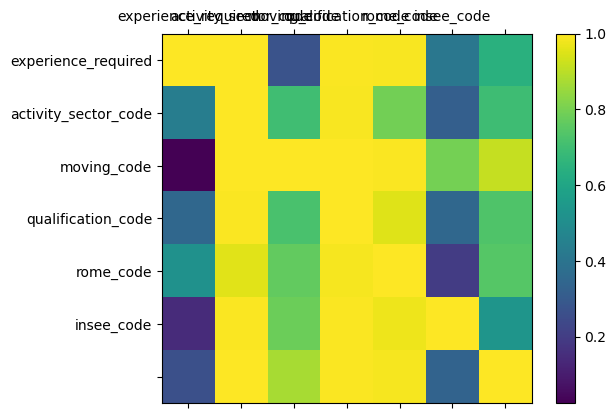

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr, interpolation='nearest')
fig.colorbar(cax)

ax.set_xticklabels(df.columns.values)
ax.set_yticklabels(df.columns.values)

plt.show()

#### Salary Analysis

In [13]:
salary=pd.read_sql_query("select * from salary", conn)
salary.head()

C:\Users\medsa\AppData\Local\Temp\ipykernel_60160\2867043087.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  salary=pd.read_sql_query("select * from salary", conn)


,salary_id,job_id,min_monthly_salary,max_monthly_salary,salary_description,max_monthly_predicted
0,1,1,1801.80,1801.80,conversion errror,0.0
1,2,2,2575.87,3144.09,conversion errror,0.0
2,3,3,2575.87,3144.09,conversion errror,0.0
3,4,4,2575.87,3144.09,conversion errror,0.0
4,5,5,2575.87,3144.09,conversion errror,0.0


(array([ 2865., 20128., 40220., 13079.,  4589.,   638.,   428.,   791.,
          168.,    61.]),
 array([1.0000e+00, 1.0009e+03, 2.0008e+03, 3.0007e+03, 4.0006e+03,
        5.0005e+03, 6.0004e+03, 7.0003e+03, 8.0002e+03, 9.0001e+03,
        1.0000e+04]),
 <BarContainer object of 10 artists>)

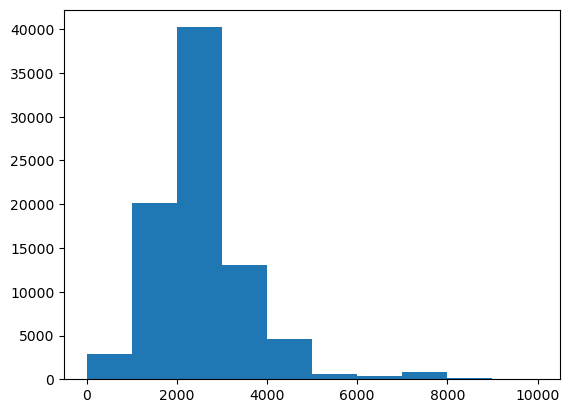

In [14]:
plt.hist(salary['min_monthly_salary'],range=(1,10000), bins=10)
#plt.show()

In [15]:
total_bins=5
labels=[i for i in range(total_bins)]
salary["salary_label"] = pd.qcut(salary['min_monthly_salary'], [i/total_bins for i in range(total_bins+1)], labels=labels)

#### Format job_tab

In [16]:
#### remove columns with a lot of NA
job=job_tab.loc[:,job_tab.isna().sum()==0]
job.loc[:,"insee_code"]=job["insee_code"]//1000*1000

In [17]:
cols_to_drop=["description","creation_date","update_date","internal_id","title"]
job=job.loc[:,~job.columns.isin(cols_to_drop)]

In [18]:
##### one hot encoding
ohe = OneHotEncoder( drop="first", sparse=False)
columns=list(job.columns)
columns.remove("job_id")
fit=ohe.fit_transform(job.loc[:,columns])
#job.loc[:,columns]

C:\Users\medsa\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [19]:
pca_properties=PCA(n_components=120)
fitted_pca_properties=pca_properties.fit_transform(fit)
formatted_job_properties=pd.DataFrame(fitted_pca_properties)
formatted_job_properties.columns=["prop_" +str(i) for i in formatted_job_properties.columns] 

In [20]:
formatted_job_properties["job_id"]=job["job_id"]

In [21]:
formatted_job_properties

,prop_0,prop_1,prop_2,prop_3,prop_4,prop_5,prop_6,prop_7,prop_8,prop_9,...,prop_111,prop_112,prop_113,prop_114,prop_115,prop_116,prop_117,prop_118,prop_119,job_id
0,0.348988,0.003131,-0.156623,-0.029404,0.049554,-0.023853,0.008524,-0.001841,0.025538,0.212346,...,0.005428,-0.000007,0.005422,0.004835,-0.001929,-0.015584,-0.000899,-0.002288,0.009690,1
1,0.466901,0.084314,-0.345757,-0.103121,0.798434,0.153916,0.064071,0.061687,-0.086967,-0.242650,...,0.143819,-0.029669,0.074405,0.058258,0.136706,-0.070556,-0.362172,-0.183922,-0.301742,2
2,0.466901,0.084314,-0.345757,-0.103121,0.798434,0.153916,0.064071,0.061687,-0.086967,-0.242650,...,0.143819,-0.029669,0.074405,0.058258,0.136706,-0.070556,-0.362172,-0.183922,-0.301742,3
3,0.466901,0.084314,-0.345757,-0.103121,0.798434,0.153916,0.064071,0.061687,-0.086967,-0.242650,...,0.143819,-0.029669,0.074405,0.058258,0.136706,-0.070556,-0.362172,-0.183922,-0.301742,4
4,0.466901,0.084314,-0.345757,-0.103121,0.798434,0.153916,0.064071,0.061687,-0.086967,-0.242650,...,0.143819,-0.029669,0.074405,0.058258,0.136706,-0.070556,-0.362172,-0.183922,-0.301742,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83126,-0.570819,-0.205086,-0.122805,-0.377030,-0.264410,0.752471,0.157778,-0.046205,-0.079830,0.048946,...,0.000516,0.009626,0.002332,0.004198,0.002230,0.000103,-0.000315,-0.004357,0.012339,83127
83127,0.561205,0.023894,-0.622806,-0.327749,-0.765652,0.632646,0.137521,-0.127061,-0.022168,-0.278016,...,-0.000827,0.009732,-0.002728,0.004953,0.005022,0.000514,-0.005531,-0.004675,0.011676,83128
83128,-0.608758,-0.086717,-0.010262,-0.050237,-0.044050,-0.034892,-0.049340,0.023288,0.038395,-0.030726,...,-0.007604,0.012667,-0.008359,0.009229,-0.008038,-0.007573,-0.010382,-0.000157,0.014268,83129
83129,0.343111,-0.131047,-0.228652,-0.368437,-0.183441,0.757620,0.200962,-0.067768,-0.080803,0.222944,...,0.004633,0.003906,0.005639,0.009572,0.000236,-0.011679,0.003814,-0.007981,0.011743,83130


In [22]:
pca_properties.explained_variance_ratio_.sum()

0.8503864085878575

#### Format competencies to be added

In [23]:
competencies=pd.read_sql_query("select * from competencies",conn)

C:\Users\medsa\AppData\Local\Temp\ipykernel_60160\457283102.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  competencies=pd.read_sql_query("select * from competencies",conn)


In [24]:
job_compt=pd.read_sql_query("select * from job_competency",conn)

C:\Users\medsa\AppData\Local\Temp\ipykernel_60160\2106566623.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  job_compt=pd.read_sql_query("select * from job_competency",conn)


In [25]:
pivoted_compt=pd.pivot_table(job_compt,index=['job_id'],columns=["competency_code"],aggfunc="count",margins=True).reset_index()
pivoted_compt.columns=['job_id']+["X_"+str(i[1]) for i in pivoted_compt.columns[1:]]
job_id=pivoted_compt["job_id"]
pivoted_compt=pivoted_compt.loc[:,~pivoted_compt.columns.isin(["job_id","X_All"])]
pivoted_compt=pivoted_compt.fillna(0)

In [26]:
pca=PCA(n_components=100)

In [27]:
fitted_values=pca.fit_transform(pivoted_compt)

In [28]:
job_pca_competencies=pd.DataFrame(fitted_values)
job_pca_competencies.columns=["compt_"+str(i) for i in job_pca_competencies]

In [29]:
job_pca_competencies["job_id"]=job_id
job_pca_competencies.head()

,compt_0,compt_1,compt_2,compt_3,compt_4,compt_5,compt_6,compt_7,compt_8,compt_9,...,compt_91,compt_92,compt_93,compt_94,compt_95,compt_96,compt_97,compt_98,compt_99,job_id
0,-0.400226,-0.019289,0.013409,0.033448,-0.047977,-0.008439,0.001639,0.016682,-0.000869,0.014682,...,-0.005877,0.019699,-0.012162,-0.010394,-0.002188,-0.023134,-0.001928,-0.011060,0.000160,52
1,-0.377271,-0.043210,0.028684,0.067252,-0.160344,-0.113987,-0.033302,0.004958,-0.013265,0.200120,...,-0.050752,-0.010876,-0.014686,-0.013901,0.028969,-0.009108,0.030179,-0.108154,0.042211,68
2,-0.377271,-0.043210,0.028684,0.067252,-0.160344,-0.113987,-0.033302,0.004958,-0.013265,0.200120,...,-0.050752,-0.010876,-0.014686,-0.013901,0.028969,-0.009108,0.030179,-0.108154,0.042211,69
3,-0.377271,-0.043210,0.028684,0.067252,-0.160344,-0.113987,-0.033302,0.004958,-0.013265,0.200120,...,-0.050752,-0.010876,-0.014686,-0.013901,0.028969,-0.009108,0.030179,-0.108154,0.042211,70
4,-0.390658,-0.041954,0.026212,0.062975,-0.151970,-0.110458,-0.031150,0.002929,-0.012463,0.192970,...,-0.029855,-0.001461,-0.001399,-0.013655,0.025334,0.012240,0.024354,-0.080077,0.009910,71


#### Merge competencies and job

In [30]:
prepared_data = job_pca_competencies.merge(formatted_job_properties,on="job_id", how="left")

In [31]:
prepared_data.dropna()

,compt_0,compt_1,compt_2,compt_3,compt_4,compt_5,compt_6,compt_7,compt_8,compt_9,...,prop_110,prop_111,prop_112,prop_113,prop_114,prop_115,prop_116,prop_117,prop_118,prop_119
0,-0.400226,-0.019289,0.013409,0.033448,-0.047977,-0.008439,0.001639,0.016682,-0.000869,0.014682,...,-0.011306,0.010101,0.027110,0.028798,-0.019436,0.022836,0.015422,-0.002873,0.062300,0.042928
1,-0.377271,-0.043210,0.028684,0.067252,-0.160344,-0.113987,-0.033302,0.004958,-0.013265,0.200120,...,0.001605,-0.002294,0.004756,-0.004584,0.001695,0.002145,-0.004860,-0.009463,0.005323,0.018474
2,-0.377271,-0.043210,0.028684,0.067252,-0.160344,-0.113987,-0.033302,0.004958,-0.013265,0.200120,...,0.002934,0.002734,0.002009,-0.001797,-0.001158,-0.000411,-0.014473,-0.010602,0.001533,0.017588
3,-0.377271,-0.043210,0.028684,0.067252,-0.160344,-0.113987,-0.033302,0.004958,-0.013265,0.200120,...,0.000563,0.000163,0.007245,-0.001671,0.002249,0.005413,-0.001607,-0.012616,0.002774,0.014890
4,-0.390658,-0.041954,0.026212,0.062975,-0.151970,-0.110458,-0.031150,0.002929,-0.012463,0.192970,...,0.004317,0.008901,0.004222,0.011559,0.004009,0.000845,-0.016050,-0.012835,0.002746,0.010905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11713,-0.390341,0.039875,0.003965,0.022879,-0.050068,0.073397,0.062673,0.014732,0.013183,0.050430,...,-0.001125,-0.000176,0.000831,0.001052,0.006900,-0.001568,-0.009361,-0.006436,-0.000293,0.006115
11714,-0.049216,-0.593452,-0.436944,-0.321093,0.282083,0.084997,-0.051562,-0.023091,0.049624,0.009057,...,0.000253,-0.002231,-0.006499,0.001777,0.005615,-0.004725,-0.002580,0.001743,0.001607,-0.005568
11715,-0.049216,-0.593452,-0.436944,-0.321093,0.282083,0.084997,-0.051562,-0.023091,0.049624,0.009057,...,-0.001976,-0.002949,-0.004735,-0.003698,0.002412,-0.003008,0.001734,0.004899,-0.001162,-0.001475
11716,0.320874,-0.622268,-0.306258,-0.055011,0.215102,-0.173476,0.176420,-0.182059,0.131249,-0.046097,...,-0.010939,0.000516,0.009626,0.002332,0.004198,0.002230,0.000103,-0.000315,-0.004357,0.012339


#### Merge salary

In [32]:
final_data=prepared_data.merge(salary.loc[:,["job_id","salary_label"]],on="job_id")

In [33]:
final_data.isna().sum()

compt_0         0
compt_1         0
compt_2         0
compt_3         0
compt_4         0
               ..
prop_116        0
prop_117        0
prop_118        0
prop_119        0
salary_label    0
Length: 222, dtype: int64

#### Train model

In [34]:
target_cols=["salary_label"]
feats_cols= list(final_data.columns) 
feats_cols.remove("job_id")
feats_cols.remove("salary_label")
X_train, X_test, y_train, y_test = train_test_split(final_data.loc[:,feats_cols], final_data.loc[:,target_cols], test_size=0.10, random_state = 42)

In [35]:
sc = StandardScaler()
X_train[feats_cols] = sc.fit_transform(X_train[feats_cols])
X_test[feats_cols] = sc.transform(X_test[feats_cols])

In [36]:
from sklearn import tree



clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

print('Score sur ensemble train', clf.score(X_train, y_train))
print('Score sur ensemble test', clf.score(X_test, y_test))

Score sur ensemble train 0.9547695808837474
Score sur ensemble test 0.49573378839590443


In [37]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=15, random_state=0)
clf.fit(X_train, y_train)
print('Score sur ensemble train', clf.score(X_train, y_train))
print('Score sur ensemble test', clf.score(X_test, y_test))

C:\Users\medsa\AppData\Local\Temp\ipykernel_60160\2127272303.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


Score sur ensemble train 0.9097288071306656
Score sur ensemble test 0.5571672354948806


#### Model sans les compétences

In [38]:
final_data=formatted_job_properties.merge(salary.loc[:,["job_id","salary_label"]],on="job_id")

In [39]:
target_cols=["salary_label"]
feats_cols= list(final_data.columns) 
feats_cols.remove("job_id")
feats_cols.remove("salary_label")
X_train, X_test, y_train, y_test = train_test_split(final_data.loc[:,feats_cols], final_data.loc[:,target_cols], test_size=0.10, random_state = 42)

In [40]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
print('Score sur ensemble train', clf.score(X_train, y_train))
print('Score sur ensemble test', clf.score(X_test, y_test))

C:\Users\medsa\AppData\Local\Temp\ipykernel_60160\3143325971.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


Score sur ensemble train 0.6206343478086531
Score sur ensemble test 0.6030791436131826


#### Prepare Extraction

In [86]:
tab_name="job"
job_tab=pd.read_sql_query("select * from job",conn)
#### remove columns with a lot of NA
job=job_tab.loc[:,job_tab.isna().sum()==0]
job.loc[:,"insee_code"]=job["insee_code"]//1000*1000
cols_to_drop=["description","creation_date","update_date","internal_id","title"]
job=job.loc[:,~job.columns.isin(cols_to_drop)]
job.head()
#### Merge salary
salary=pd.read_sql_query("select * from salary", conn)
salary.head()
total_bins=5
labels=[i for i in range(total_bins)]
salary["salary_label"] = pd.qcut(salary['min_monthly_salary'], [i/total_bins for i in range(total_bins+1)], labels=labels)


C:\Users\medsa\AppData\Local\Temp\ipykernel_60160\1076660222.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  job_tab=pd.read_sql_query("select * from job",conn)
C:\Users\medsa\AppData\Local\Temp\ipykernel_60160\1076660222.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  salary=pd.read_sql_query("select * from salary", conn)


In [87]:
final_data=job.merge(salary.loc[:,["job_id","salary_label"]],on="job_id")

In [88]:

##### one hot encoding
ohe = OneHotEncoder( drop="first", sparse=False)
columns=list(job.columns)
columns.remove("job_id")
fit=ohe.fit_transform(job.loc[:,columns])
#job.loc[:,columns]
print(columns)

C:\Users\medsa\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['rome_code', 'experience_required', 'experience_length_months', 'is_alternance', 'candidates_missing', 'moving_code', 'insee_code']


In [96]:
# Traitement des variables catégorielles 
categorical_features = columns
categorical_transformer = OneHotEncoder(drop = "first", sparse=False)
pca_properties=PCA(n_components=120)
#Column Tranformer pour appliquer les transformations sur certaines colonnes
preprocessor = Pipeline(
    steps=[("preprocessor", categorical_transformer), 
           ("pca", pca_properties)]
)
final_preprocessor = ColumnTransformer(
    transformers=[
        ("cat",preprocessor, categorical_features)
    ]
)

from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(max_depth=10, random_state=0)

estimator= Pipeline(steps=[("preprocess",final_preprocessor),
                           ("RF_estimator",RF)])


In [95]:
preprocessor.fit_transform(X_train)

C:\Users\medsa\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[ 3.50848406e-01, -7.09122517e-02, -1.92074122e-01, ...,
         6.24547997e-03, -1.04262323e-02, -6.54596986e-03],
       [ 6.46972571e-01, -3.44181667e-01,  6.27414753e-01, ...,
        -5.25553090e-03, -1.39807243e-03,  6.30441803e-03],
       [-5.69052180e-01,  7.54140304e-01,  3.12756469e-01, ...,
         9.34677717e-03, -3.35174184e-04, -6.23446783e-03],
       ...,
       [-5.70541557e-01, -2.00707679e-01, -1.32346508e-01, ...,
        -2.98255270e-03,  6.50767081e-03, -1.17386172e-03],
       [ 4.14125366e-01,  4.01360585e-02, -2.07822131e-01, ...,
        -8.63864483e-03,  1.21969271e-03, -4.80739422e-04],
       [ 4.94440444e-01,  5.32325731e-03, -3.86794468e-01, ...,
        -4.12493481e-03,  4.32963502e-03,  3.01305187e-03]])

In [97]:
target_col="salary_label"
feats_cols=columns
X_train, X_test, y_train, y_test = train_test_split(final_data.loc[:,feats_cols], final_data.loc[:,target_cols], test_size=0.10, random_state = 42)

In [81]:
X_train.head()

,rome_code,experience_required,experience_length_months,is_alternance,candidates_missing,moving_code,insee_code
41068,I1304,E,0,0,0,1,93000
651,C1206,E,12,0,0,1,75000
25776,E1108,D,0,0,0,3,92000
6752,K1303,D,0,0,0,1,75000
55455,F1106,E,0,0,0,1,75000


In [99]:
estimator.fit(X_train, y_train)  

C:\Users\medsa\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\medsa\anaconda3\Lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('preprocessor',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False)),
                                                                  ('pca',
                                                                   PCA(n_components=120))]),
                                                  ['rome_code',
                                                   'experience_required',
                                                   'experience_length_months',
                                                   'is_alternance',
                                                   'candidates_missing',
                                                   'moving_code',
                                                   'insee_code'])])),
                ('RF_estimator',
                 RandomForestClassifier(max_depth=10, random_state=0))])

In [112]:
X_test=X_test[X_test["rome_code"].isin(X_train["rome_code"])]
y_test=y_test[y_test.index.isin(X_test.index)]

In [113]:
accuracy=estimator.score(X_test,y_test)
print(accuracy)

0.5989163154726068


In [71]:
import mlflow
from mlflow.models import infer_signature
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

In [115]:
params = {
    "solver": "lbfgs",
    "max_iter": 1000,
    "multi_class": "auto",
    "random_state": 8888,
}

with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Random forest for France travail data")

    # Infer the model signature
    signature = infer_signature(X_train, estimator.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=estimator,
        artifact_path="FranceTravailSalaryExtract",
        signature=signature,
        input_example=X_train,
        registered_model_name="tracking-quickstart",
    )

C:\Users\medsa\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Successfully registered model 'tracking-quickstart'.
2025/03/01 09:43:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-quickstart, version 1
Created version '1' of model 'tracking-quickstart'.


🏃 View run popular-snipe-226 at: http://127.0.0.1:8080/#/experiments/0/runs/0eca2d4273ed42a0bd060afd1b620598
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/0


In [127]:
# Load the model back for predictions as a generic Python Function model
model_name = "tracking-quickstart"
model_version = "latest"

# Load the model from the Model Registry
model_uri = f"models:/{model_name}/{model_version}"
model = mlflow.sklearn.load_model(model_uri)

predictions = model.predict(X_test)

predictions

array([0, 0, 4, ..., 4, 2, 1], dtype=int64)